# Remove Boxes Demo

In [1]:
%load_ext autoreload
%autoreload 2

This notebook shows how to remove boxes from a form as these boxes can cause OCR misreads if the text overlaps with the boundaries of the box

In [2]:
import sys
import os
sys.path.append(".")
import matplotlib.pyplot as plt
from requests import get, post, delete
import time

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

__root_common__ = 'common.py'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__root_common__), '..')))

import numpy as np
from boxdetect import config
from common.common import compute_partial_ratio, compute_ratio, get_text_from_ocr

config.thickness = 1
file_name = '../Data/SBI-Account-Opening-Form-Sample-Filled-1.jpg'


In [3]:
# scaling_factors param is the one that affects performance the most
# - it defines all the scaling factors that should be used while processing to search for rectangles
# - the more and more diverse the better 
# - smaller value -> faster processing time
# - going below 0.4 is risky because image can turn blury and might generate more false positives
print("Default scaling factors: ", config.scaling_factors)


config.min_w, config.max_w = (8,12)
config.min_h, config.max_h = (10,14)
config.scaling_factors = [1.0, 1.1, 1.2, 1.3, 1.4, 1.6]
config.wh_ratio_range = (0.6, 1.0)
config.vertical_max_distance = 5
config.horizontal_max_distance_multiplier = 3


Default scaling factors:  [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


# Now we autodetect boxes on the form - this is a poor quality image

In [4]:
from boxdetect.pipelines import process_image

rects, grouping_rects, img, output_image = process_image(
    file_name, config=config, plot=False)

Processing file:  ../Data/SBI-Account-Opening-Form-Sample-Filled-1.jpg


## Each rectangle is a big region of box rectangles
 (x, y, w, h)

In [5]:
grouping_rects

[(110, 54, 125, 12),
 (264, 54, 84, 12),
 (110, 68, 125, 13),
 (10, 194, 474, 14),
 (10, 221, 474, 14),
 (61, 239, 84, 13),
 (95, 257, 144, 12),
 (36, 279, 143, 12),
 (363, 279, 123, 12),
 (13, 314, 121, 13),
 (155, 314, 132, 14),
 (328, 314, 158, 13),
 (13, 336, 473, 13),
 (74, 358, 411, 13),
 (31, 378, 144, 15),
 (194, 379, 81, 14),
 (299, 378, 187, 15),
 (70, 400, 142, 13),
 (270, 400, 132, 13),
 (113, 436, 14, 14),
 (13, 451, 473, 14),
 (13, 470, 472, 12),
 (74, 488, 412, 14),
 (31, 506, 144, 13),
 (193, 506, 82, 13),
 (299, 506, 187, 13),
 (62, 525, 142, 13),
 (254, 525, 132, 13),
 (67, 543, 419, 13),
 (138, 638, 30, 13),
 (512, 636, 26, 21),
 (62, 653, 143, 12),
 (322, 653, 163, 12),
 (47, 667, 123, 12),
 (296, 729, 14, 14)]

## Let's see what has been detected 

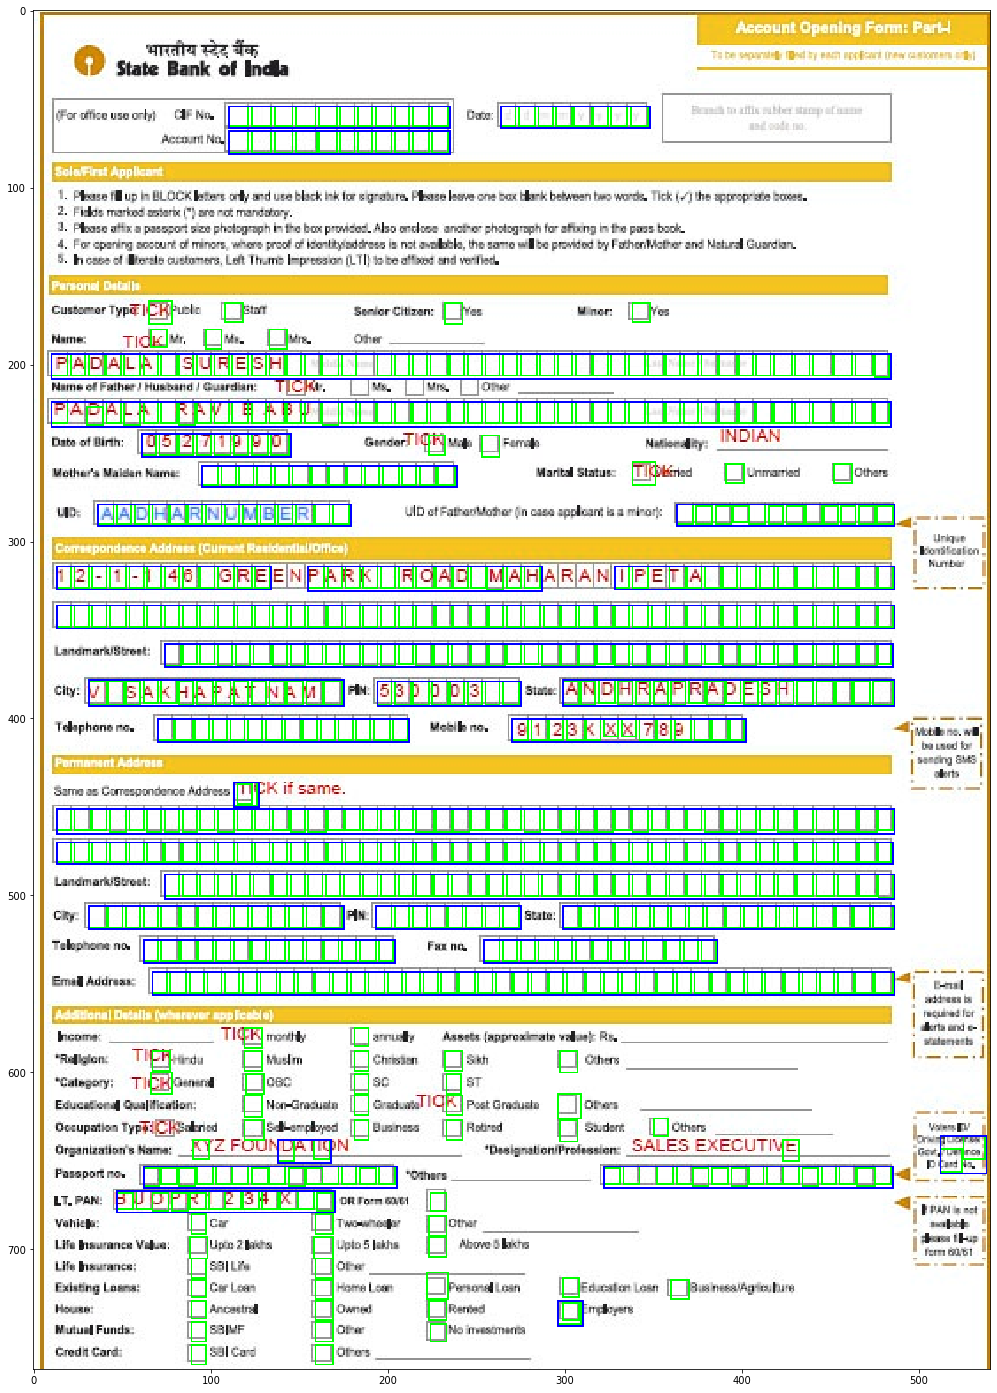

In [6]:
plt.figure(figsize=(25,25))
plt.imshow(output_image)

# Here you can interactively extract each section that the detect boxes has identified - use this to tune the sensitivity of the region extraction

In [ ]:
from ipywidgets import interact

@interact(i=(0, len(grouping_rects)-1))
def extract_region(i):
    
    window1 = 1   # Tweak these sensitivity values
    window2 = 0.01  # Tweak these sensitivity values
    
    y1 = int(grouping_rects[i][1] + (window1 * grouping_rects[i][3]))   
    y2 = int(grouping_rects[i][1] - (window2 * grouping_rects[i][3]))
    x1 = int(grouping_rects[i][0] + (window1 * grouping_rects[i][2]))
    x2 = int(grouping_rects[i][0] - (window2 * grouping_rects[i][2]))
    roi = output_image[y2:y1, x2:x1]
    plt.imshow(roi)
    


# Let's drilldown on the City field 

True

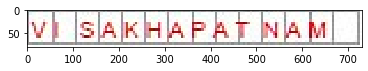

In [22]:
window1 = 1   # Tweak these sensitivity values
window2 = 0.01  # Tweak these sensitivity values

# Let's take the city field as an example
i = 14
    
y1 = int(grouping_rects[i][1] + (window1 * grouping_rects[i][3]))   
y2 = int(grouping_rects[i][1] - (window2 * grouping_rects[i][3]))
x1 = int(grouping_rects[i][0] + (window1 * grouping_rects[i][2]))
x2 = int(grouping_rects[i][0] - (window2 * grouping_rects[i][2]))
roi = output_image[y2:y1, x2:x1]


image = cv2.imread(file_name)
roi = image[y2:y1, x2:x1]
scale_percent = 500 # percent of original size
width = int(roi.shape[1] * scale_percent / 100)
height = int(roi.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
resized = cv2.resize(roi, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)
 
cv2.imwrite(os.path.join('../Data/','city.jpg'), resized)

In [8]:
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

import numpy as np


%matplotlib inline 

## Set up our environment variables

In [9]:
# We will set up some of the environment variables here and others later in the notebook to keep things clear
# Set the values here marked with SET THIS HERE
class Config:
    """
    Read from .env file
    """
    REGION = 'eastus'  # The region Form Recognizer and OCR are deployed
    SUBSCRIPTION_KEY = '05e053d185984175931176e7b88fb536'  # CogSvc key
    

In [10]:
def call_ocr(file_path, file_name, region, subscription_key):
    """
    Let's only call OCR if we need to
    :param file_path: Path to file to OCR
    :param file_name: File name to OCR
    :return: The json response of the OCR
    """

    headers = {
        "Ocp-Apim-Subscription-Key": subscription_key,
        "Content-Type": "image/jpeg"
    }

    with open(os.path.join(file_path, file_name), 'rb') as ocr_file:
        file_content = ocr_file.read()

    operation_location = ""
    print(f"Analyzing file {file_name}...")
    analyze_result_response = None

    try:
        url = f"https://{region}.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze"
        print(url)
        resp = post(url=url, data=file_content, headers=headers)
        print(resp, resp.status_code, resp.text)
        operation_location = resp.headers['Operation-Location']
        print(f"Analyze Operation Location: {operation_location}")
    except Exception as e:
        print(f"Error analyzing file: {e}")

    # Getting response result
    if (operation_location != ""):
        resp_analyze = get(url=operation_location, headers=headers)
        analyze_result_response = resp_analyze.json()
        count = 0
        max_retry = 30
        try:
            while (count < max_retry and resp_analyze.status_code == 200 and (
                    analyze_result_response['status'] == 'running' or analyze_result_response[
                'status'] == 'notStarted')):
                resp_analyze = get(url=operation_location, headers=headers)
                analyze_result_response = resp_analyze.json()
                time.sleep(0.5)
                count += 1
            print(f"File {file_name} status: {analyze_result_response['status']}")
        except Exception as e:
            print(f"Error analyzing file: {e}")
    
    return analyze_result_response

## Let's call OCR to see what we can extract from the file as is

In [11]:
GT = 'VI SAKHAPATNAM'    # This is the ground truth value for the field
result = call_ocr('../Data/', 'city.jpg', Config.REGION, Config.SUBSCRIPTION_KEY)


Analyzing file city.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze
<Response [202]> 202 
Analyze Operation Location: https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyzeResults/84e05e0a-580b-448a-bc70-2875e372877a
File city.jpg status: succeeded


In [19]:
par_score = compute_partial_ratio(GT, get_text_from_ocr(result))
score = compute_ratio(GT, get_text_from_ocr(result))
print(f"Score {(par_score + score) / 2}")
print(f"GT: {GT} OCR: {get_text_from_ocr(result)}")

Score 94.0
GT: VI SAKHAPATNAM OCR: SAKHAPATNAM


In [21]:
DATA_PATH = '../Data/'
gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# Remove horizontal
#horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    
    
# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)


#cv2.imshow('thresh', thresh)
cv2.imwrite(DATA_PATH + 'thresh.png', thresh)
#cv2.imshow('detected_lines', detected_lines)
cv2.imwrite(DATA_PATH + 'detected.png', detected_lines)
#cv2.imshow('image', roi)
cv2.imwrite(DATA_PATH + 'roi.png', roi)
#cv2.imshow('result', result)
cv2.imwrite(DATA_PATH + 'result.png', result)
#cv2.waitKey(0)

True

In [ ]:
res = call_ocr(DATA_PATH, DATA_PATH + 'roi.png')
#print(res)

par_score = compute_partial_ratio(GT, get_text_from_ocr(res))
print(f"Partial Score {par_score}")
score = compute_ratio(GT, get_text_from_ocr(res))
print(f"Score {score}")
print(get_text_from_ocr(res))

In [23]:
# This is used and needs to be non-interactive
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

%matplotlib inline 

import cv2 as cv
import numpy as np
import argparse
erosion_size = 0
max_elem = 2
max_kernel_size = 21



def apply_erosion():
    
    src = cv.imread(DATA_PATH + 'region_dilation.png')
    #src = cv.imread('/Users/shanepeckham/Downloads/detect-pps-outputs/region_erosion.png')
    erosion_size = 1
   
    erosion_type = 0
    erosion_type = cv.MORPH_RECT
    element = cv.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    erosion_dst = cv.erode(src, element)
    cv2.imwrite(DATA_PATH + 'region_erosion.png',erosion_dst)

    
def apply_dilatation(src):
    #dilatation_size = cv.getTrackbarPos(title_trackbar_kernel_size, title_dilatation_window)
    #print('dilatation_size', dilatation_size)
    dilatation_type = 0
    dilatation_size = 1
    #val_type = cv.getTrackbarPos(title_trackbar_element_type, title_dilatation_window)
    #print('val_type', val_type)
    #if val_type == 0:
    dilatation_type = cv.MORPH_RECT
    #elif val_type == 1:
    #    dilatation_type = cv.MORPH_CROSS
    #elif val_type == 2:
    #    dilatation_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    dilatation_dst = cv.dilate(src, element)
    #cv.imshow(title_dilatation_window, dilatation_dst)
    cv2.imwrite(DATA_PATH + 'region_dilation.png',dilatation_dst)

src = cv.imread(DATA_PATH + 'city.jpg')



apply_dilatation(src)
apply_erosion()
#cv.waitKey()

In [30]:
result = call_ocr(DATA_PATH, 'region_erosion.png', Config.REGION, Config.SUBSCRIPTION_KEY)

par_score = compute_partial_ratio(GT, get_text_from_ocr(result))
score = compute_ratio(GT, get_text_from_ocr(result))
print(f"Score {(par_score + score) / 2}")
print(f"GT: {GT} OCR Erosion: {get_text_from_ocr(result)}")


result = call_ocr(DATA_PATH, 'region_dilation.png', Config.REGION, Config.SUBSCRIPTION_KEY)

par_score = compute_partial_ratio(GT, get_text_from_ocr(result))
score = compute_ratio(GT, get_text_from_ocr(result))
print(f"Score {(par_score + score) / 2}")
print(f"GT: {GT} OCR Dilation: {get_text_from_ocr(result)}")

Analyzing file region_erosion.png...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze
<Response [202]> 202 
Analyze Operation Location: https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyzeResults/94457887-3d12-4521-a86f-b821d72b8876
File region_erosion.png status: succeeded
Score 94.0
GT: VI SAKHAPATNAM OCR Erosion: SAKHAPATNAM
Analyzing file region_dilation.png...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze
<Response [202]> 202 
Analyze Operation Location: https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyzeResults/e043d230-6559-49ed-a64a-172b8580c0ae
File region_dilation.png status: succeeded
Score 72.0
GT: VI SAKHAPATNAM OCR Dilation: SAKH


In [ ]:
import cv2
import numpy as np
DATA_PATH = "/Users/shanepeckham/Downloads/Distinte bonifici singoli/"

def get_projection(image, vert=False):

    axis = 1
    if vert:
        axis = 0

    # Compute the sums of the rows - the projection
    # row_sums = sum_rows(image)
    row_sums = np.sum(image, axis=axis)

    # normalise to 0 to 255
    max_row = np.max(row_sums)
    row_sums = (row_sums / max_row) * 255
    return row_sums

def load_image(file_path, squarify=False, invert=True):

    img = cv2.imread(file_path, 0)

    if invert:
        img = 255 - img

    if squarify:
        h, w = img.shape
        min_dim = min(h, w)
        img = img[0:min_dim, 0:min_dim]

    return img

def get_projection(image, vert=False):

    axis = 1
    if vert:
        axis = 0

    # Compute the sums of the rows - the projection
    # row_sums = sum_rows(image)
    row_sums = np.sum(image, axis=axis)

    # normalise to 0 to 255
    max_row = np.max(row_sums)
    row_sums = (row_sums / max_row) * 255
    return row_sums


def find_runs(sum_rows, level=0):
    """
    Identify sequence of rows where the sum is high.
    This indicates existence of text (where the sum is above level)
    Do the same for sequences where the sum is low
    This indicates a line break - the abscence of text
    """
    lows = []
    highs = []
    num_rows = len(sum_rows)
    old_low_high = -1
    curr_run = []

    for pos in range(num_rows):

        if sum_rows[pos] <= level:
            low_high = 0
        else:
            low_high = 1

        if old_low_high == -1:
            old_low_high = low_high
            curr_run.append(pos)
            continue

        if old_low_high != low_high:
            # new run
            if old_low_high == 0:
                lows.append(curr_run)
            else:
                highs.append(curr_run)

            old_low_high = low_high
            curr_run = []

        curr_run.append(pos)

    return lows, highs




def analyze_runs(lows):

    print("lows")
    lmr_low = []
    for run in lows:
        middle_of_run = ((run[-1] - run[0])/2) + run[0]
        run_width = run[-1] - run[0]
        lmr_low.append([run[0], middle_of_run, run[-1], run_width])

        print(f"num points: {len(run)}"
              f" run_width: {run_width}"
              f" middle pos of run: {middle_of_run}")

    # extract details of each 'low' - start, middle, end, width
    widths = []
    num_seqs = len(lmr_low)
    prev_lmr = None
    for i in range(num_seqs):
        lmr = lmr_low[i]
        if prev_lmr is None:
            prev_lmr = lmr_low[i]
            continue

        pl, pm, pr, pw = prev_lmr
        l, m, r, w = lmr

        widths.append(m-pm)
        prev_lmr = lmr

    median_width = np.median(widths)

    print(np.median(widths))
    print(np.average(widths))

    start = lmr_low[0][1]
    end = lmr_low[-1][1]

    return start, end, median_width, lmr_low


def show_image(img, image_original, row_sums, line_breaks, vert=False):

    # draw the line breaks calculated from the
    # projection lows
    i = 0
    if not vert:
        for line_break_pos in line_breaks:
            #i += 1
            img[line_break_pos, :] = 255
            #ROI = image_original[line_break_pos, :]
            #cv2.imwrite(DATA_PATH + 'ROI2_{}.png'.format(str(i)), ROI)
    else:
        for line_break_pos in line_breaks:
            #print(line_break_pos)
            #i += 1
            img[:, line_break_pos] = 255
            #ROI = image_original[int(line_break_pos/2):int(line_break_pos*2), int(line_break_pos/2):int(line_break_pos*2)]
            #cv2.imwrite(DATA_PATH + 'ROI2_{}.png'.format(str(i)), ROI)

    img = 255 - img
    #cv2.imshow('projection results', img)
    cv2.imwrite(DATA_PATH + 'projection results.png', img)
    #cv2.waitKey(0)



image_file_path = '/Users/shanepeckham/Downloads/Distinte bonifici singoli/region_erosion.png'
is_vert_projection = True
image = load_image(image_file_path)

_, thresholded_image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)

projection = get_projection(thresholded_image, is_vert_projection)
print(projection)

# find the locations of text lines
# lows are line breaks, highs are text
lows, highs = find_runs(projection)


# get the line break dimensions
start, end, median_width, lmr_low = analyze_runs(lows)
print('start', start)
print('end', end)
print('median_width', median_width)
print('lmr_low', lmr_low)

print('highs', highs)
image_original = load_image(image_file_path)
#ROI =  image_original[0:int(7.5), 15]
ROI = image_original [:15,8:40]
cv2.imwrite(DATA_PATH + 'ROI21_{}.png'.format('test'), ROI)
##roi = gray[y1:y2, x1:x2]

# take the mid point in the middle of a line break
# where the width is greater than 3 (skips very narrow gaps)
line_breaks = [int(lmr[1]) for lmr in lmr_low 
if lmr[3] > 5]

# show the skew corrected image and the line breaks.
show_image(
    image,
    image_original,
    projection,
    line_breaks,
    is_vert_projection)



In [ ]:
file_name = DATA_PATH + 'projection results.png'

res = call_ocr(DATA_PATH, file_name)

par_score = compute_partial_ratio(GT, get_text_from_ocr(res))
print(f"Partial Score {par_score}")
score = compute_ratio(GT, get_text_from_ocr(res))
print(f"Score {score}")

Not sure we are doing anything here

In [ ]:
DATA_PATH = "/Users/shanepeckham/Downloads/Distinte bonifici singoli/"
filename = 'projection results.png'
roi = cv2.imread(DATA_PATH + filename)

gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# Remove horizontal
#horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
print('detected_lines', detected_lines)

cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('cnts', cnts)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    print(c)
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    area = cv2.contourArea(c)
    if area < 1000 and area > 50:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - thresh[y:y+h, x:x+w]
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        cv2.imwrite(DATA_PATH + 'ROI_{}.png'.format(ROI_number), ROI)
        ROI_number += 1
    
    
# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)


#cv2.imshow('thresh', thresh)
cv2.imwrite(DATA_PATH + 'threshpp.png', thresh)
#cv2.imshow('detected_lines', detected_lines)
cv2.imwrite(DATA_PATH + 'detectedpp.png', detected_lines)
#cv2.imshow('image', roi)
cv2.imwrite(DATA_PATH + 'roipp.png', roi)
#cv2.imshow('result', result)
cv2.imwrite(DATA_PATH + 'resultpp.png', result)
#cv2.waitKey(0)

In [ ]:
file_name = DATA_PATH + 'resultpp.png'

res = call_ocr(DATA_PATH, file_name)

par_score = compute_partial_ratio(GT, get_text_from_ocr(res))
print(f"Partial Score {par_score}")
score = compute_ratio(GT, get_text_from_ocr(res))
print(f"Score {score}")

In [ ]:
file_name = DATA_PATH + 'roipp.png'

res = call_ocr(DATA_PATH, file_name)

par_score = compute_partial_ratio(GT, get_text_from_ocr(res))
print(f"Partial Score {par_score}")
score = compute_ratio(GT, get_text_from_ocr(res))
print(f"Score {score}")

In [ ]:
file_name = DATA_PATH + 'threshpp.png'

res = call_ocr(DATA_PATH, file_name)

par_score = compute_partial_ratio(GT, get_text_from_ocr(res))
print(f"Partial Score {par_score}")
score = compute_ratio(GT, get_text_from_ocr(res))
print(f"Score {score}")

# Define points
pts = np.array([[542, 107], [562, 102], [582, 110], [598, 142], [600, 192], [601, 225], [592, 261], [572, 263], [551, 245], [526, 220], [520, 188], [518, 152], [525, 127], [524, 107]], dtype=np.int32)


In [ ]:

def predict_char(model, gray, idx):
    w = gray.size[0]
    h = gray.size[1]
    gray = gray.convert('L')
    gray = gray.point(lambda x: 0 if x < 180 else 255, '1')
    x = int(64 - (w / 2))
    y = int(64 - (h / 2))
    canvas = Image.new('L', (128, 128), (255))
    canvas.paste(gray, box=(x, y))

    #canvas = ImageOps.invert(canvas)
    canvas = np.array(canvas)
    canvas = canvas / 255.0


    # test_data = np.array(gray)
    test_output = model(Variable(torch.FloatTensor(canvas).unsqueeze(0).unsqueeze(0)))
    pred = test_output.data.max(1, keepdim=True)[1]
    pred = np.array(pred).squeeze(0).squeeze(0)

    for key, value in idx.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if value == pred:
            #print('Predict character', key)

            return key

In [ ]:
# This is used

import cv2
import os
import numpy as np
from imutils import contours
DATA_PATH = "/Users/shanepeckham/Downloads/Distinte bonifici singoli/"
#DATA_PATH = '/Users/shanepeckham/Downloads/detect-pps-outputs/'

image = cv2.imread(os.path.join(DATA_PATH, 'projection results.png'))
mask = np.zeros(image.shape, dtype=np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")
ROI_number = 0
res_string = ''
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000 and area > 50:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - thresh[y:y+h, x:x+w]
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        cv2.imwrite(DATA_PATH + 'ROI_{}.png'.format(ROI_number), ROI)
        pil_im = Image.open(DATA_PATH + 'ROI_{}.png'.format(ROI_number))
        digit = predict_char(model, pil_im, idx)
        res_string += digit 
#cv2.imshow('mask', mask)
#cv2.imshow('thresh', thresh)
#cv2.waitKey()
print(res_string)

par_score = compute_partial_ratio(GT, res_string)
print(f"Partial Score {par_score}")
score = compute_ratio(GT, res_string)
print(f"Score {score}")

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import cv2
import numpy as np
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)  #(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 128, 5, 1)  #(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(460800, 512)  #(107648, 2048)(9216, 128)
        self.fc2 = nn.Linear(512, 512)  #(1024, 512)
        self.fc3 = nn.Linear(512, 47)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output


idx = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12,
       'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23,
       'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34,
       'a': 35, 'b': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 'n': 42, 'q': 43, 'r': 44, 't': 45, 'u': 46}

device = torch.device("cpu")

kwargs = {}


model = Net().to(device)


tar = torch.load('/Users/shanepeckham/sources/nlp/enmist_model/checkpoint_5.pt', map_location=torch.device('cpu'))
state_dict = tar['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v

model.load_state_dict(state_dict)
#optimizer.load_state_dict(checkpoint['optimizer'])
#torch.load("mnist_cnn.pt")

model.eval()




  

# From blog https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26

In [ ]:
# Read the image
#doc = '/Users/shanepeckham/Documents/boxes_data/Gedoc_1 (2).tiff'
doc = '/Users/shanepeckham/Documents/boxes_data/output23.png'
img = cv2.imread(doc, 0)
 
# Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite("Image_bin.jpg",img_bin)

In [ ]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

In [ ]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
cv2.imwrite("horizontal_lines.jpg",horizontal_lines_img)

In [ ]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_final_bin.jpg",img_final_bin)

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [ ]:
# Find contours for image, which will detect all the boxes
contours, _ = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

In [ ]:
cropped_dir_path = '/Users/shanepeckham/Documents/boxes_data/output2/'

idx = 0
for c in contours:
    # Returns the location and width,height for every contour
    #x, y, w, h = cv2.boundingRect(c) 
    x, y, w, h = cv2.boxFilter(c)
    print(x, y, w, h)
    idx = str(x) + '_' + str(y) + '_' + str(w) + '-' + str(h)
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    #if (w > 100 and h > 5) and w > 3*h:
    #idx += 1
    new_img = img[y:y+h, x:x+w]
    cv2.imwrite(cropped_dir_path+str(idx) + '.png', new_img)

# Projection code from repo 

In [ ]:
import projection as p
import cv2

image_file_path = '/Users/shanepeckham/Documents/boxes_data/output2/0_0_2251-738.png'
is_vert_projection = True
image = p.load_image(image_file_path)

_, thresholded_image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)

projection = p.get_projection(thresholded_image, is_vert_projection)

# find the locations of text lines
# lows are line breaks, highs are text
lows, highs = p.find_runs(projection)

# get the line break dimensions
start, end, median_width, lmr_low = p.analyze_runs(lows)

# take the mid point in the middle of a line break
# where the width is greater than 3 (skips very narrow gaps)
line_breaks = [int(lmr[1]) for lmr in lmr_low if lmr[3] > 5]

# show the skew corrected image and the line breaks.
p.show_image(
    image,
    projection,
    line_breaks,
    is_vert_projection)